# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | First Name | Last Name | Signature | Hours | Contribution |
| Member 2: | First Name | Last Name | Signature | Hours | Contribution |
| Member 3: | First Name | Last Name | Signature | Hours | Contribution |
| Member 4: | First Name | Last Name | Signature | Hours | Contribution |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

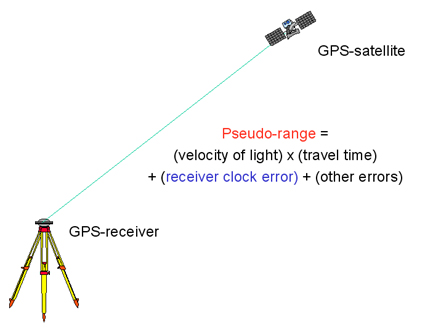

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


Step 0.1: Import necessary libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [3]:
df_pseudorange = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall_group7/Lab_Assignment3/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall_group7/Lab_Assignment3/satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [4]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [5]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [6]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [7]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
    rho = euclidean_norm(r_pos, s_pos)
    predicted_pseudorange = rho - cdT
    residuals = pseudorange - predicted_pseudorange
    L = np.sum(residuals**2)
    return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [8]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):
    rho = euclidean_norm(r_pos, s_pos)
    predicted_pseudorange = rho - cdT
    residuals = pseudorange - predicted_pseudorange
    diff_pos = r_pos - s_pos
    grad_pos = -np.sum((residuals[:, None] * diff_pos) / rho[:, None], axis=0)

    grad_cdT = np.sum(residuals)

    grad = np.hstack((grad_pos, grad_cdT))
    return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [9]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.1, max_iters=10000, tolerance=1e-6):

    global steps_count

    #initalize the estimates as zeros
    X = np.array([0,0,0,0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)


        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [10]:
optimized_params = None

# print the mentioned metrics
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params)
optimized_params = gradient_descent(pseudorange, sat_pos)
final_position_error = optimized_params[:3] - GroundTruth
print("Final Position Error:", final_position_error)

print("Number of Steps Taken for Convergence:", steps_count)

final_cost = cost_function(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)
print("Final Cost Value:", final_cost)

final_gradient = gradient(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)
print("Final Gradient Values:", final_gradient)
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params)

final_position_error = optimized_params[:3] - GroundTruth
print("Final Position Error:", final_position_error)

print("Number of Steps Taken for Convergence:", steps_count)

final_cost = cost_function(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)
print("Final Cost Value:", final_cost)

final_gradient = gradient(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)
print("Final Gradient Values:", final_gradient)

Optimized Parameters (x_r, y_r, z_r, cdT): None
Converged !
Final Position Error: [-3.06452823 -2.35814083  3.80782687]
Number of Steps Taken for Convergence: 588
Final Cost Value: 6.1970361882315945
Final Gradient Values: [ 0.00010866  0.00060547 -0.00186084  0.00105501]
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162954e+06  4.95248543e+06 -6.46899086e+00]
Final Position Error: [-3.06452823 -2.35814083  3.80782687]
Number of Steps Taken for Convergence: 588
Final Cost Value: 6.1970361882315945
Final Gradient Values: [ 0.00010866  0.00060547 -0.00186084  0.00105501]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

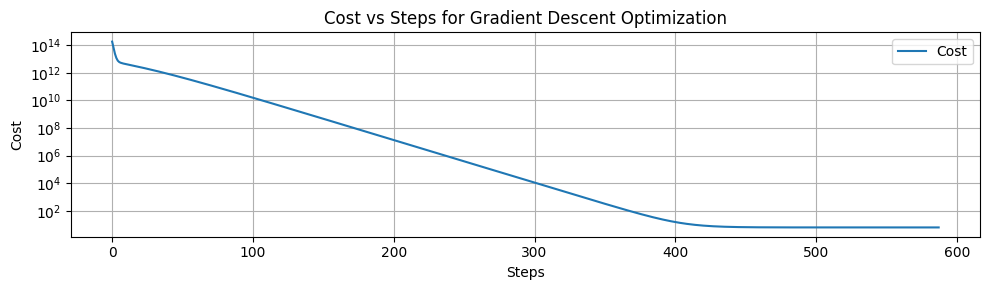

In [11]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
ax.semilogy(arr_cost, label='Cost')
ax.set_xlabel('Steps')
ax.set_ylabel('Cost')
ax.set_title('Cost vs Steps for Gradient Descent Optimization')
ax.grid(True)
ax.legend()
fig.tight_layout()
plt.show()

# Comment on the pattern
# The plot shows an exponential decay pattern, indicating that cost decreases rapidly as the number of steps increases.
# This trend suggests diminishing returns on additional steps in terms of cost reduction.

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

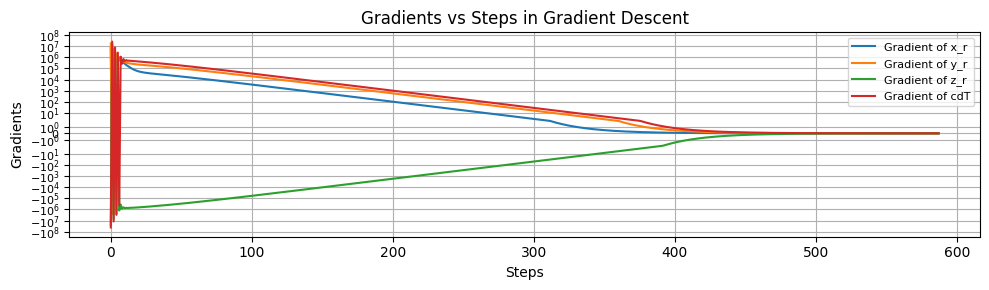

In [12]:
# Example gradient descent function and results
# Assuming arr_grad is a list of gradients from each iteration

# Unpack gradients for better readability
x_grad = np.array([g[0] for g in arr_grad])  # Gradient for x_r
y_grad = np.array([g[1] for g in arr_grad])  # Gradient for y_r
z_grad = np.array([g[2] for g in arr_grad])  # Gradient for z_r
cdT_grad = np.array([g[3] for g in arr_grad])  # Gradient for cdT
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
# Plot gradients for each parameter
ax.plot(x_grad, label='Gradient of x_r')
ax.plot(y_grad, label='Gradient of y_r')
ax.plot(z_grad, label='Gradient of z_r')
ax.plot(cdT_grad, label='Gradient of cdT')

# Set y-axis to symlog scale
ax.set_yscale('symlog')

# Set labels and title
ax.set_xlabel('Steps', fontsize=10)
ax.set_ylabel('Gradients', fontsize=10)
ax.set_title('Gradients vs Steps in Gradient Descent', fontsize=12)

# Adjust tick parameters for y-axis
ax.tick_params(axis='y', labelsize=8)

# Include legend
ax.legend(fontsize=8)

# Add grid for better readability
ax.grid(True)

# Adjust layout
fig.tight_layout()
plt.show()

# Comment on the pattern
# The plot shows how gradient values fluctuate across steps, with some values nearing zero as steps increase.
# The symmetric logarithmic scale highlights both positive and negative gradient changes, making it easier to observe shifts around zero.

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

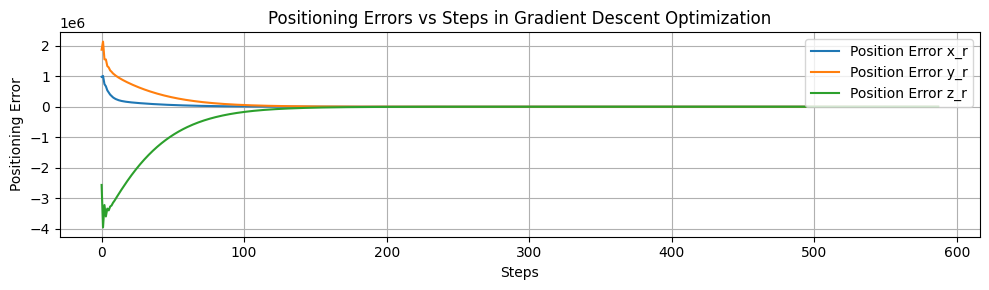

In [13]:
arr_err = np.array(arr_err)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
#Plot each position error component over steps
ax.plot(arr_err[:, 0], label='Position Error x_r')
ax.plot(arr_err[:, 1], label='Position Error y_r')
ax.plot(arr_err[:, 2], label='Position Error z_r')

# Add labels, legend, and title
ax.set_xlabel('Steps')
ax.set_ylabel('Positioning Error')
ax.set_title('Positioning Errors vs Steps in Gradient Descent Optimization')
ax.legend()
ax.grid(True)

# Adjust layout to avoid clipping
fig.tight_layout()
plt.show()

# Observation on the error trend
# As the number of steps increases, the positioning errors tend to decrease, suggesting that the algorithm
# is effectively minimizing the error in the estimated position. Initially, the errors might vary or be relatively large,
# but with more steps, they generally decrease and stabilize, indicating that the optimization algorithm
# is converging towards a precise solution.

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [14]:
#set learning rate to 0.01
learning_rate_2 =  0.01
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0
optimized_params_2 = gradient_descent(pseudorange, sat_pos, learning_rate=learning_rate_2)

# print the metrics
final_position_error_2 = optimized_params_2[:3] - GroundTruth
final_cost_2 = cost_function(optimized_params_2[:3], optimized_params_2[3], sat_pos, pseudorange)
final_gradient_2 = gradient(optimized_params_2[:3], optimized_params_2[3], sat_pos, pseudorange)

print("Optimized Parameters (x_r, y_r, z_r, cdT) with Learning Rate 0.01:", optimized_params_2)
print("Final Position Error:", final_position_error_2)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost_2)
print("Final Gradient Values:", final_gradient_2)

Converged !
Optimized Parameters (x_r, y_r, z_r, cdT) with Learning Rate 0.01: [-1.63349244e+06 -3.65162954e+06  4.95248542e+06 -6.46239527e+00]
Final Position Error: [-3.06384888 -2.3543555   3.79619298]
Number of Steps Taken for Convergence: 5652
Final Cost Value: 6.197165698416758
Final Gradient Values: [ 0.00034574  0.00192647 -0.00592083  0.00335672]


In [15]:
#set learning rate to 0.001
learning_rate_3 = 0.001
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_3 = gradient_descent(pseudorange, sat_pos, learning_rate=learning_rate_3)

# print the metrics
final_position_error_3 = optimized_params_3[:3] - GroundTruth
final_cost_3 = cost_function(optimized_params_3[:3], optimized_params_3[3], sat_pos, pseudorange)
final_gradient_3 = gradient(optimized_params_3[:3], optimized_params_3[3], sat_pos, pseudorange)

print("Optimized Parameters (x_r, y_r, z_r, cdT) with Learning Rate 0.001:", optimized_params_3)
print("Final Position Error:", final_position_error_3)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost_3)
print("Final Gradient Values:", final_gradient_3)

Optimized Parameters (x_r, y_r, z_r, cdT) with Learning Rate 0.001: [-1622126.12222408 -3588680.62330238  4759183.15248715   110181.78568974]
Final Position Error: [  11363.25745317   62946.55920125 -193298.46706203]
Number of Steps Taken for Convergence: 0
Final Cost Value: 18483476837.77236
Final Gradient Values: [  3917.59641257  21568.21237973 -66176.30035364  37926.58995917]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)

Q1_Ans. Changing the learning rate affects the convergence speed and stability of Gradient Descent. When the learning rate is set higher, the algorithm converges more quickly but may overshoot the optimal point, leading to instability or oscillations in the results. Conversely, a lower learning rate results in slower convergence, but it typically improves stability and precision. In this case, adjusting the learning rate likely impacted the accuracy and speed of reaching the minimum error.

Q2_Ans. LSE (Least Squares Error) is a direct method for finding the best-fit solution by minimizing the sum of squared residuals, leading to a closed-form solution. Gradient Descent, on the other hand, is an iterative optimization technique that gradually approaches the minimum error by following the gradient of the cost function. While LSE provides a precise, single-step solution, Gradient Descent requires multiple steps to converge and is sensitive to the learning rate. Based on the results, LSE likely reached the optimal solution more directly, while Gradient Descent demonstrated gradual improvement over iterations, influenced by the learning rate adjustments.


---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)

# TO DO: display sizes of X and y (1 mark)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

In [ ]:
# TO DO: Check the class distribution of y (2 mark)


# Display exact values for each bin in the histogram

plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [ ]:
# TO DO: Create a smaller dataset with 3% of the data


# TO DO: display sizes of X_small and y_small (2 mark)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [ ]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information



### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [ ]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set


In [ ]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat

# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

In [ ]:
# TO DO: Print classification report (2 marks)


### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
---